# Retrieving results for specific buildings

Now that we have a database with information on all buildings, dimensioned components and estimated material amounts for each building, we can start exploiting the database and writing queries to retrieve information for specific buildings. We can import data into Pandas dataframe in Python, which will allow a broad range of analyses.

# Setup

In [4]:
import psycopg as pg
import pandas as pd

In [5]:
params='dbname=macrocomponents user=postgres password=19Ni93co44PG!'

# Retrieving information for a building

First, we can write a function that queries the PostgresQL database to retrieve generic information about the building:

In [20]:
def properties_one_building(bbr_id):
    results=pd.DataFrame({'bbr_id':[],'construction_year':[],'bbr_use_category':[],'built_area':[], 'total_building_area':[], 'n_floors':[], 'roof_material':[], 'wall_material':[]})
    
    SQL="""
    SELECT
    b.bbr_id,
    b.construction_year,
    b.bbr_use_category,
    b.built_area,
    b.total_building_area,
    b.n_floors,
    b.roof_material,
    b.wall_material
    FROM buildings b
    WHERE bbr_id=%s
    """
    
    try:
        conn = pg.connect(params)
        cur=conn.cursor()
        
        cur.execute(SQL,(bbr_id,))
        row=cur.fetchone()     
              
        while row is not None:
            results.loc[len(results)]=list(row)
            row=cur.fetchone()

        conn.commit()
        cur.close()
        
        return(results)

    except (Exception, pg.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()    


Then, we can write a function that retrieves material amounts for each element in the particular building. The query converts potential material amounts that would be conveyed in m3 into kg.

In [21]:
def results_one_building(bbr_id):
    results=pd.DataFrame({'bbr_id':[],'element':[],'product':[],'weight':[],'material_type':[]})
    
    SQL="""
    SELECT
    rma.bbr_id,
    rma.element,
    rma.product,
    weight,
    material_type
    FROM results_material_amounts rma
    INNER JOIN products pr ON rma.product=pr.name,
    LATERAL (SELECT (CASE WHEN unit='KG' THEN amount WHEN unit='M3' THEN amount*pr.density ELSE NULL END) AS weight) lt
    WHERE rma.bbr_id=%s
    ORDER BY element  
    """
    
    try:
        conn = pg.connect(params)
        cur=conn.cursor()
        
        cur.execute(SQL,(bbr_id,))
        row=cur.fetchone()     
              
        while row is not None:
            results.loc[len(results)]=list(row) # Insert the row we retrieved from the PostgresQL database into the Pandas dataframe
            row=cur.fetchone()

        conn.commit()
        cur.close()
        
        return(results)

    except (Exception, pg.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close() 

Alternatively, we can also retrieve the total amounts of each type of material in the building. This function is a bit longer and more complex, because it aggregates rows from the "buildings_material_amounts" table into separate columns.

In [22]:
def material_amounts_one_building(bbr_id):
    results=pd.DataFrame({'bbr_id':[],'clay':[],'cement_mortar':[],'concrete':[],'gypsum_plaster':[], 'metal':[],'wood':[],'wool':[],'other':[]})
    
    SQL1="""
    CREATE TEMP TABLE IF NOT EXISTS agg_material (
        bbr_id varchar(50) PRIMARY KEY,
        Clay real,
        Cement_mortar real,
        Concrete real,
        Gypsum_plaster real,
        Metal real,
        Wood real,
        Wool real,
        Other real);"""
    
    SQL2="""
    WITH t AS(
    SELECT
    rma.bbr_id,
    rma.element,
    rma.product,
    weight,
    material_type
    FROM results_material_amounts rma
    INNER JOIN buildings b ON b.bbr_id=rma.bbr_id
    INNER JOIN products pr ON rma.product=pr.name,
    LATERAL (SELECT (CASE WHEN unit='KG' THEN amount WHEN unit='M3' THEN amount*pr.density ELSE NULL END) AS weight) lt
    WHERE rma.bbr_id=%s
    )

    SELECT
    bbr_id,
    SUM(weight) weightsum,
    material_type
    INTO TEMPORARY TABLE t2
    FROM t
    GROUP BY material_type, bbr_id;    
    """

    SQLclay="""
    INSERT INTO agg_material(bbr_id, Clay)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Clay'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Clay) = (EXCLUDED.bbr_id, EXCLUDED.Clay);
    """
    
    SQLcement="""
    INSERT INTO agg_material(bbr_id, Cement_mortar)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Cement-mortar' 
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Cement_mortar) = (EXCLUDED.bbr_id, EXCLUDED.Cement_mortar);
    """

    SQLconcrete="""
    INSERT INTO agg_material(bbr_id, Concrete)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Concrete'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Concrete) = (EXCLUDED.bbr_id, EXCLUDED.Concrete);
    """

    SQLgypsum="""
    INSERT INTO agg_material(bbr_id, Gypsum_plaster)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Gypsum-plaster'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Gypsum_plaster) = (EXCLUDED.bbr_id, EXCLUDED.Gypsum_plaster);
    """

    SQLmetal="""
    INSERT INTO agg_material(bbr_id, Metal)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Metal'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Metal) = (EXCLUDED.bbr_id, EXCLUDED.Metal);
    """

    SQLwood="""
    INSERT INTO agg_material(bbr_id, Wood)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Wood'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Wood) = (EXCLUDED.bbr_id, EXCLUDED.Wood);
    """

    SQLwool="""
    INSERT INTO agg_material(bbr_id, Wool)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Wool'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Wool) = (EXCLUDED.bbr_id, EXCLUDED.Wool);
    """

    SQLother="""
    INSERT INTO agg_material(bbr_id, Other)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Other'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Other) = (EXCLUDED.bbr_id, EXCLUDED.Other);
    """

    SQLselect="SELECT * FROM agg_material"
    
    try:
        conn = pg.connect(params)
        cur=conn.cursor()
        
        cur.execute(SQL1)
        cur.execute(SQL2,(bbr_id,))
        cur.execute(SQLclay)
        cur.execute(SQLcement)
        cur.execute(SQLconcrete)
        cur.execute(SQLgypsum)
        cur.execute(SQLmetal)
        cur.execute(SQLwood)
        cur.execute(SQLwool)
        cur.execute(SQLother)
        cur.execute(SQLselect)       

        row=cur.fetchone()
        
        while row is not None:
            results.loc[len(results)]=list(row)
            row=cur.fetchone()

        conn.commit()
        cur.close()
        
        return(results)

    except (Exception, pg.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close() 

In [23]:
def material_amounts_all():
    results=pd.DataFrame({'bbr_id':[],'clay':[],'cement_mortar':[],'concrete':[],'gypsum_plaster':[], 'metal':[],'wood':[],'wool':[],'other':[]})
    
    SQL1="""
    CREATE TEMP TABLE IF NOT EXISTS agg_material (
        bbr_id varchar(50) PRIMARY KEY,
        Clay real,
        Cement_mortar real,
        Concrete real,
        Gypsum_plaster real,
        Metal real,
        Wood real,
        Wool real,
        Other real);"""
    
    SQL2="""
    WITH t AS(
    SELECT
    rma.bbr_id,
    rma.element,
    rma.product,
    weight,
    material_type
    FROM results_material_amounts rma
    INNER JOIN buildings b ON b.bbr_id=rma.bbr_id
    INNER JOIN products pr ON rma.product=pr.name,
    LATERAL (SELECT (CASE WHEN unit='KG' THEN amount WHEN unit='M3' THEN amount*pr.density ELSE NULL END) AS weight) lt
    )

    SELECT
    bbr_id,
    SUM(weight) weightsum,
    material_type
    INTO TEMPORARY TABLE t2
    FROM t
    GROUP BY material_type, bbr_id;    
    """

    SQLclay="""
    INSERT INTO agg_material(bbr_id, Clay)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Clay'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Clay) = (EXCLUDED.bbr_id, EXCLUDED.Clay);
    """
    
    SQLcement="""
    INSERT INTO agg_material(bbr_id, Cement_mortar)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Cement-mortar' 
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Cement_mortar) = (EXCLUDED.bbr_id, EXCLUDED.Cement_mortar);
    """

    SQLconcrete="""
    INSERT INTO agg_material(bbr_id, Concrete)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Concrete'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Concrete) = (EXCLUDED.bbr_id, EXCLUDED.Concrete);
    """

    SQLgypsum="""
    INSERT INTO agg_material(bbr_id, Gypsum_plaster)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Gypsum-plaster'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Gypsum_plaster) = (EXCLUDED.bbr_id, EXCLUDED.Gypsum_plaster);
    """

    SQLmetal="""
    INSERT INTO agg_material(bbr_id, Metal)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Metal'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Metal) = (EXCLUDED.bbr_id, EXCLUDED.Metal);
    """

    SQLwood="""
    INSERT INTO agg_material(bbr_id, Wood)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Wood'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Wood) = (EXCLUDED.bbr_id, EXCLUDED.Wood);
    """

    SQLwool="""
    INSERT INTO agg_material(bbr_id, Wool)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Wool'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Wool) = (EXCLUDED.bbr_id, EXCLUDED.Wool);
    """

    SQLother="""
    INSERT INTO agg_material(bbr_id, Other)
    SELECT 
    bbr_id,
    weightsum
    FROM t2
    WHERE material_type = 'Other'
    ON CONFLICT ON CONSTRAINT agg_material_pkey DO UPDATE SET (bbr_id, Other) = (EXCLUDED.bbr_id, EXCLUDED.Other);
    """

    SQLselect="SELECT * FROM agg_material"
    
    try:
        conn = pg.connect(params)
        cur=conn.cursor()
        
        cur.execute(SQL1)
        cur.execute(SQL2)
        cur.execute(SQLclay)
        cur.execute(SQLcement)
        cur.execute(SQLconcrete)
        cur.execute(SQLgypsum)
        cur.execute(SQLmetal)
        cur.execute(SQLwood)
        cur.execute(SQLwool)
        cur.execute(SQLother)
        cur.execute(SQLselect)       

        row=cur.fetchone()
        
        while row is not None:
            results.loc[len(results)]=list(row)
            row=cur.fetchone()

        conn.commit()
        cur.close()
        
        return(results)

    except (Exception, pg.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close() 

In [56]:
results_one_building('7A2AF1D0-CE0C-4784-BB3F-1054A34C4F60'.lower())

,bbr_id,element,product,weight,material_type
0,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,ext_wall,Lightweight concrete block,41709.357548,Concrete
1,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,ext_wall,Lightweight concrete block,69515.603256,Concrete
2,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,ext_wall,Lime gypsum interior plaster,2949.146605,Gypsum-plaster
3,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,ext_wall,Steel bars (thin),800.482666,Metal
4,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,ext_wall,Steel bars (thin),1263.920044,Metal
5,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,ext_wall,Lime cement mortar,1348.181248,Cement-mortar
6,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,ext_wall,Mineral wool (blowable),1558.834648,Wool
7,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,floor,"Precast lightweight concrete floor element, th...",107877.203125,Concrete
8,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,floor,Lime gypsum interior plaster,9582.999706,Gypsum-plaster
9,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,floor,Reinforcement steel wire,12649.559570,Metal


In [27]:
properties_one_building('001f5af1-1df6-42cc-8766-730f27a94b43')

,bbr_id,construction_year,bbr_use_category,built_area,total_building_area,n_floors,roof_material,wall_material
0,001f5af1-1df6-42cc-8766-730f27a94b43,None,110,187,187,1,4,1


In [221]:
material_amounts_one_building('7A2AF1D0-CE0C-4784-BB3F-1054A34C4F60'.lower())

,bbr_id,clay,cement_mortar,concrete,gypsum_plaster,metal,wood,wool,other
0,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,None,26327.227,1287358.2,22167.934,34943.664,37192.27,7595.6685,1369.0


In [156]:
allresults=material_amounts_all()

Import Bhuvans results as CSV then inner join

In [10]:
bhuvans=pd.read_csv('C:/Users/KJ35FA/Downloads/bhuvans data.csv', sep=';')

In [16]:
bhuvans

,id,geom,bygning_id,ydervaeg_kode,suppydervaegmat,tag_kode,supptagdaekmat,opfoerelse_aar,ombyg_aar,byg_anvend_kode,...,aggregates,clay,concrete,glasscera,metals,mortargyp,plastics,timber,othermaterials,totalmaterial
0,7654,0101000020E864000048E17A1455952141EC51B89E21FF...,dec48c3b-fc23-44fc-a564-00301c6b28bf,1.0,NaN,6.0,NaN,1954,0,217,...,0.00000,1496.00000,61424.00000,0.000000,3300.000000,0.00000,0.000000,6072.000000,20064.000000,9.235600e+04
1,4469,0101000020E864000052B81E8526FB2041EC51B86E2FFC...,7a2af1d0-ce0c-4784-bb3f-1054a34c4f60,6.0,NaN,3.0,NaN,2002,0,323,...,0.00000,770232.00000,857889.00000,0.000000,419604.000000,507261.00000,0.000000,44547.000000,784602.000000,3.384135e+06
2,12776,0101000020E86400005C8FC2F5D958214152B81EE525FB...,b57e41dd-b16a-4741-829a-34fc062285dd,1.0,NaN,5.0,NaN,1954,1966,120,...,58820.00122,65840.00244,64320.00122,290.000009,1030.000019,19189.99939,160.000002,9669.999695,1000.000000,2.203300e+05
3,6890,0101000020E8640000B81E856B24C020418FC2F5386FF3...,48fec5ae-cd04-47c5-a2f9-f2ee479c0093,6.0,NaN,1.0,NaN,1965,1969,222,...,0.00000,888210.00000,981340.00000,0.000000,169580.000000,601870.00000,0.000000,118150.000000,659276.983000,3.418427e+06
4,16434,0101000020E864000033333333479E2041666666D648F5...,cf6c1071-da82-4f77-b940-17e22424ec10,1.0,NaN,5.0,NaN,1933,1996,120,...,41496.59882,126313.39530,66542.00000,320.099995,1067.000000,28042.70059,97.000000,12978.600300,1086.399981,2.779341e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28909,2490589,0101000020E8640000333333B3C2D420413333331306FA...,f3db359d-2d5a-4ef4-8f94-e5ed64fe5eba,1.0,NaN,3.0,NaN,1870,1975,110,...,38569.60083,173046.40330,92017.59668,788.800026,2230.399948,54740.00000,27.200000,20821.600830,2339.200104,3.845808e+05
28910,2490574,0101000020E86400003D0AD7A388A221417B14AE378904...,2c36c7d6-f94a-41ba-b855-f01ec7d0ace0,5.0,NaN,1.0,NaN,2016,0,120,...,12848.00049,22863.99902,82607.99805,1151.999969,1280.000000,13168.00049,575.999985,7487.999878,2288.000031,1.442880e+05
28911,2490576,0101000020E864000052B81E85931321418FC2F5583EFC...,b9bcc58d-2613-4919-a8a9-f0b025ed87a5,1.0,NaN,6.0,NaN,1920,0,217,...,0.00000,1326.00000,54444.00000,0.000000,2925.000000,0.00000,0.000000,5382.000000,17784.000000,8.186100e+04
28912,2491084,0101000020E8640000333333332454214166666666A2FA...,d18b8f12-6128-4920-ad27-8b3e7d7c17f9,1.0,NaN,3.0,NaN,1930,2004,120,...,39987.60086,179408.40340,95400.59656,817.800027,2312.399946,56752.50000,28.200000,21587.100860,2425.200108,3.987198e+05


In [12]:
def lowercase(str):
    return str.lower()

In [15]:
bhuvans['bygning_id']=bhuvans['bygning_id'].transform(lowercase)

In [17]:
compare=pd.merge(allresults,bhuvans,left_on='bbr_id',right_on='bygning_id')

In [18]:
compare

,bbr_id,clay_x,cement_mortar,concrete_x,gypsum_plaster,metal,wood,wool,other,id,...,aggregates,clay_y,concrete_y,glasscera,metals,mortargyp,plastics,timber,othermaterials,totalmaterial
0,1e706529-2bb1-43bf-ba4d-604b8e667f0b,None,None,None,None,None,None,None,None,1906124,...,0.000000,16864.00000,692416.00000,0.000000,37200.000000,0.000000,0.000000,68448.000000,226176.000000,1.041104e+06
1,ef2e3670-6b72-4441-98f1-0d1a44a3f82a,None,110.852005,94470.56,2079.2239,2529.48,None,None,None,2423184,...,8592.100327,15290.29935,55244.09869,770.399980,856.000000,8806.100327,385.199990,5007.599918,1530.100020,9.649260e+04
2,001f5af1-1df6-42cc-8766-730f27a94b43,None,193.73201,171834.77,3633.784,4420.68,794.12665,None,None,1897655,...,19204.899430,30985.89943,103467.09770,1402.500000,2636.700071,17970.699710,710.599991,16100.699710,7068.599857,1.995664e+05
3,00aef56f-64db-423c-a55f-781a0106998d,None,176.1792,92501.52,1807.176,2198.52,394.93997,None,None,1087158,...,0.000000,47616.00000,148335.00000,0.000000,15531.000000,32085.000000,0.000000,6584.400284,46872.000000,2.970234e+05
4,05d73f4e-e0f7-4c4e-8a70-2b2bec105159,None,568.31995,298392.0,5829.6,7092.0,1274.0,None,None,942183,...,24090.000920,42869.99817,154889.99630,2159.999943,2400.000000,24690.000920,1079.999971,14039.999770,4290.000057,2.705400e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28166,aaef6a5d-e7d2-4c7f-bcfe-ff631876dfbc,1780.8953,509.881,26496.0,294.0,694.07996,595.4881,84.0,24.0,289283,...,0.000000,408.00000,16752.00000,0.000000,900.000000,0.000000,0.000000,1656.000000,5472.000000,2.518800e+04
28167,aaf0b65d-7ab5-4fe9-baa6-bb54f97531e8,70962.62,23841.756,67680.0,2599.3928,3572.0,4759.2905,329.0,94.0,1883316,...,26658.400570,119605.60230,63600.39771,545.200018,1541.599964,37835.000000,18.800000,14391.400570,1616.800072,2.658132e+05
28168,aaf0ec56-a334-4252-848e-b9bcc774a876,84337.16,24295.934,None,3595.1265,13.7,39512.11,479.5,137.0,957695,...,38853.200840,174318.80330,92694.19666,794.600026,2246.799948,55142.500000,27.400000,20974.700840,2356.400105,3.874086e+05
28169,aaf0ee83-3d26-4ced-b4fd-804a5ad186f5,96635.414,51208.215,110160.0,3959.0132,2884.0498,4145.123,535.5,153.0,1042416,...,58461.300930,152831.70370,194539.50000,489.600007,1361.699942,31472.099530,30.600000,13311.000000,780.299985,4.532778e+05


In [26]:
compare.to_csv('C:/Users/KJ35FA/Downloads/compare.csv', sep=';')

# Visualization

In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
testplot=pd.DataFrame({'year':bhuvans['opfoerelse_aar'],'floorarea':bhuvans['byg_arl_saml'],'materialperm2':bhuvans['totalmaterial']/bhuvans['byg_arl_saml']})


<AxesSubplot:xlabel='year', ylabel='floorarea'>

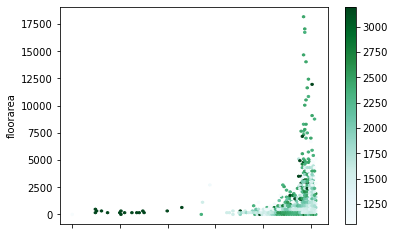

In [40]:
testplot.plot.hexbin(x='year', y='floorarea', C='materialperm2', reduce_C_function=np.mean)

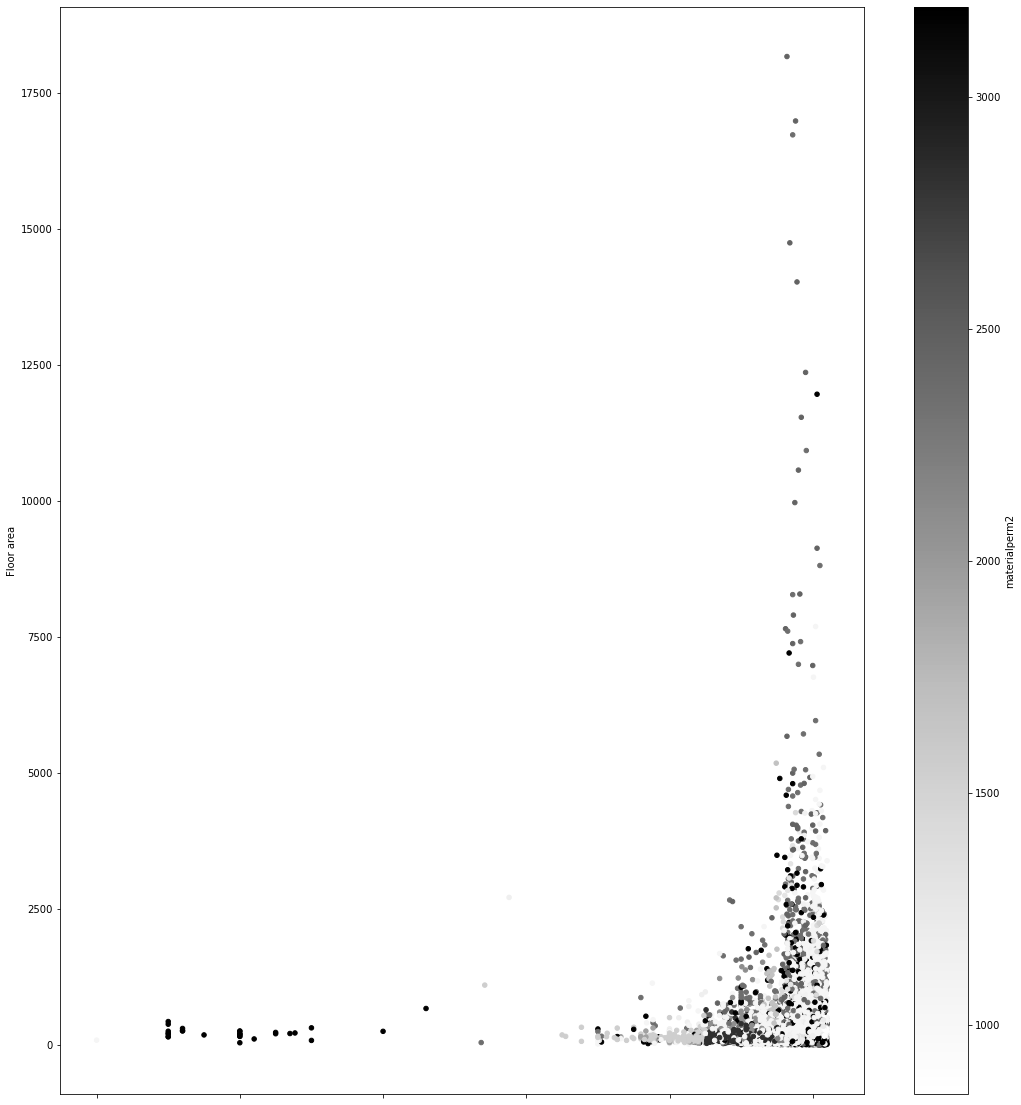

In [71]:
plot=testplot.plot.scatter(x='year', y='floorarea', c='materialperm2', figsize=(18,20), xlabel='Construction year', ylabel='Floor area')

In [76]:
plot.xaxis.set_label_coords(1000,1000)

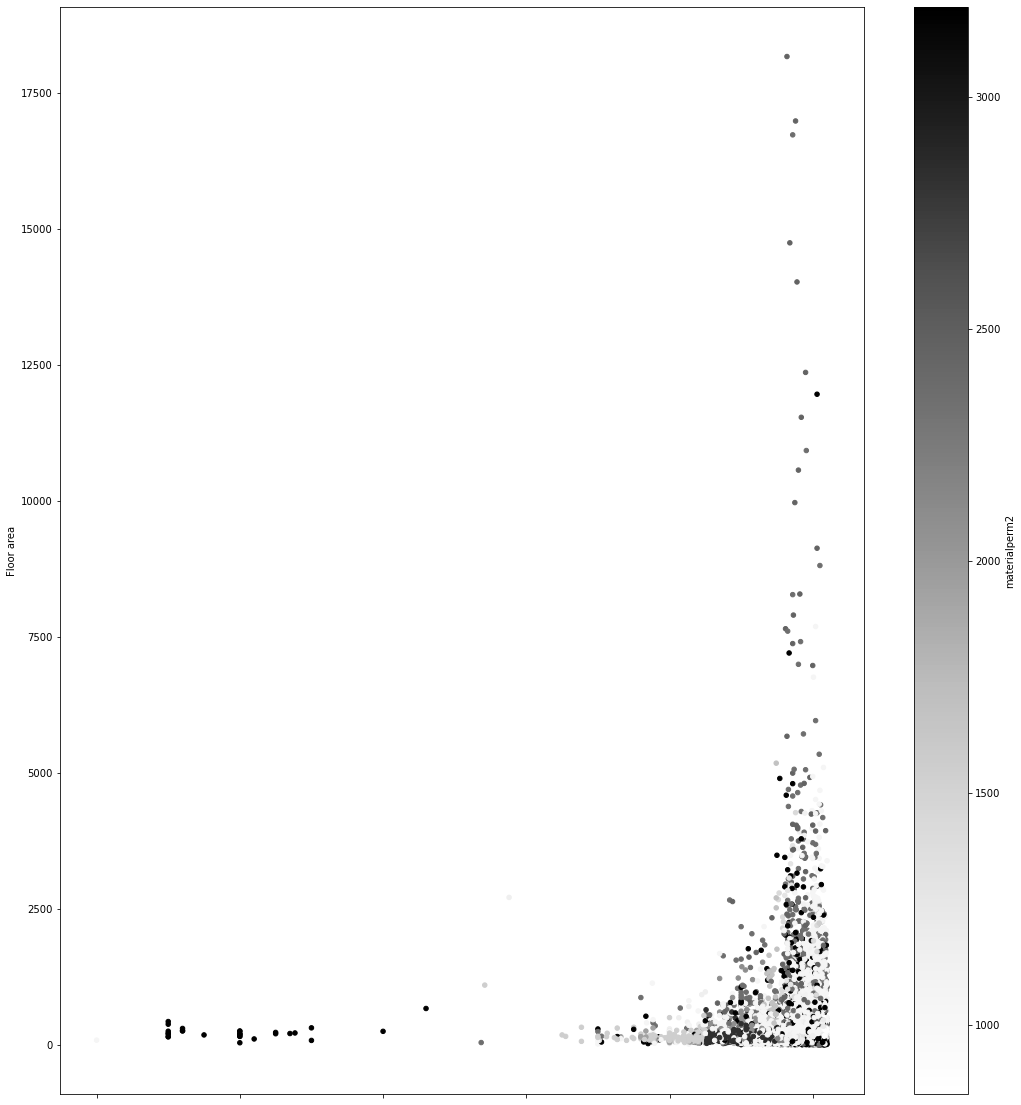

In [77]:
plot.figure

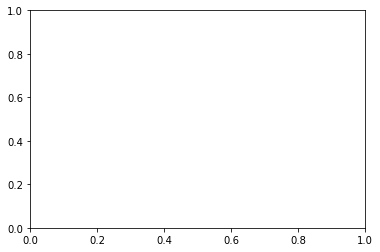

In [78]:
fig, ax=plt.subplots()

In [79]:
testplot.plot.scatter(x='year', y='floorarea', c='materialperm2', figsize=(18,20), xlabel='Construction year', ylabel='Floor area', ax=ax)

<AxesSubplot:xlabel='Construction year', ylabel='Floor area'>

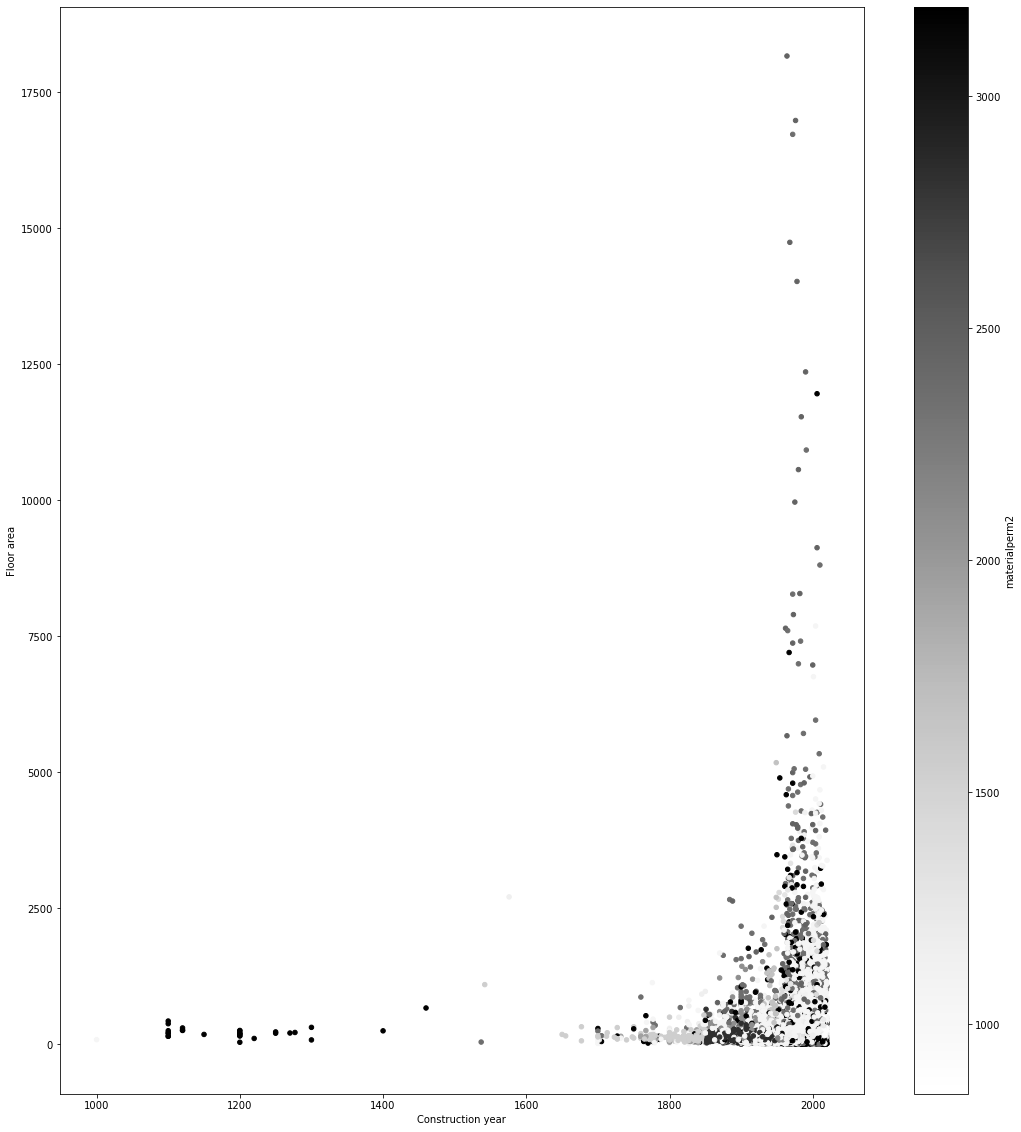

In [86]:
ax.figure

<AxesSubplot:xlabel='Construction year', ylabel='Floor area'>

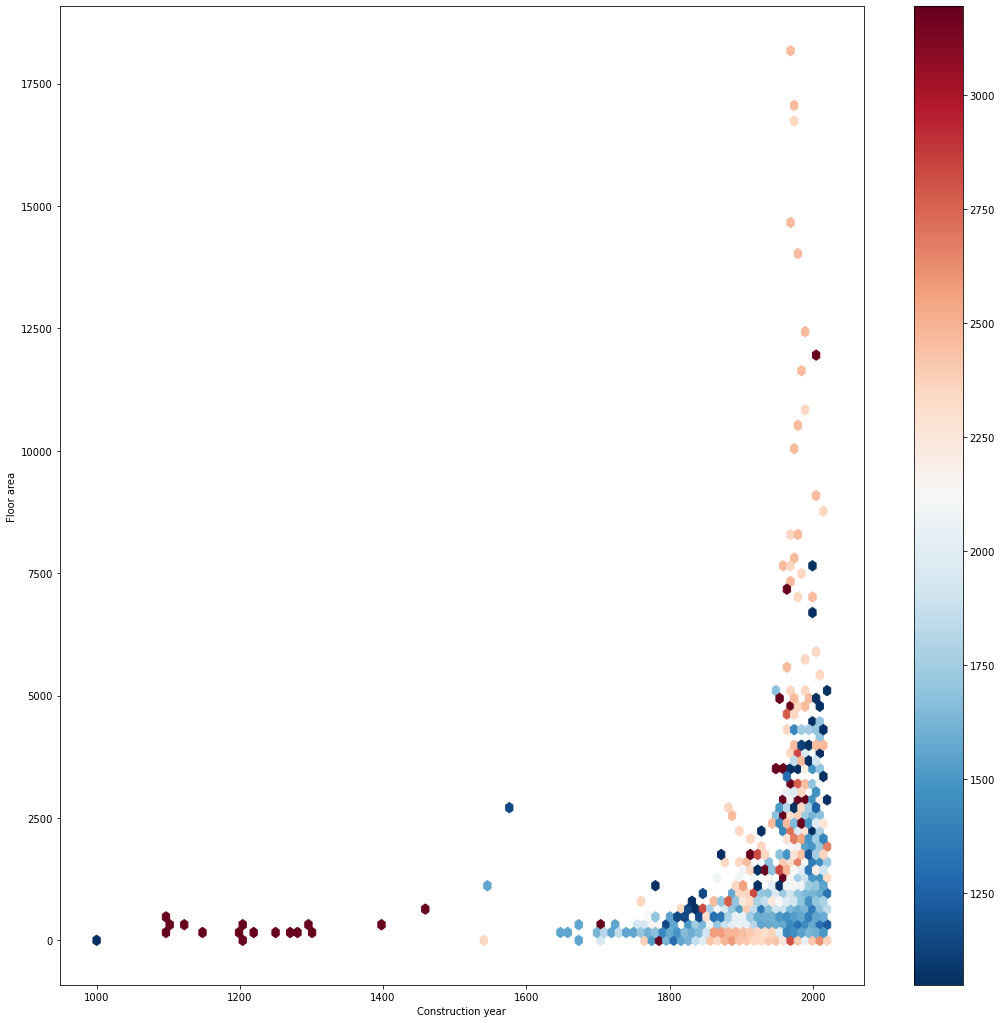

In [94]:
fig2, ax2=plt.subplots()
testplot.plot.hexbin(x='year', y='floorarea', C='materialperm2', reduce_C_function=np.mean, figsize=(18,18), xlabel='Construction year', ylabel='Floor area', ax=ax2, cmap='RdBu_r')

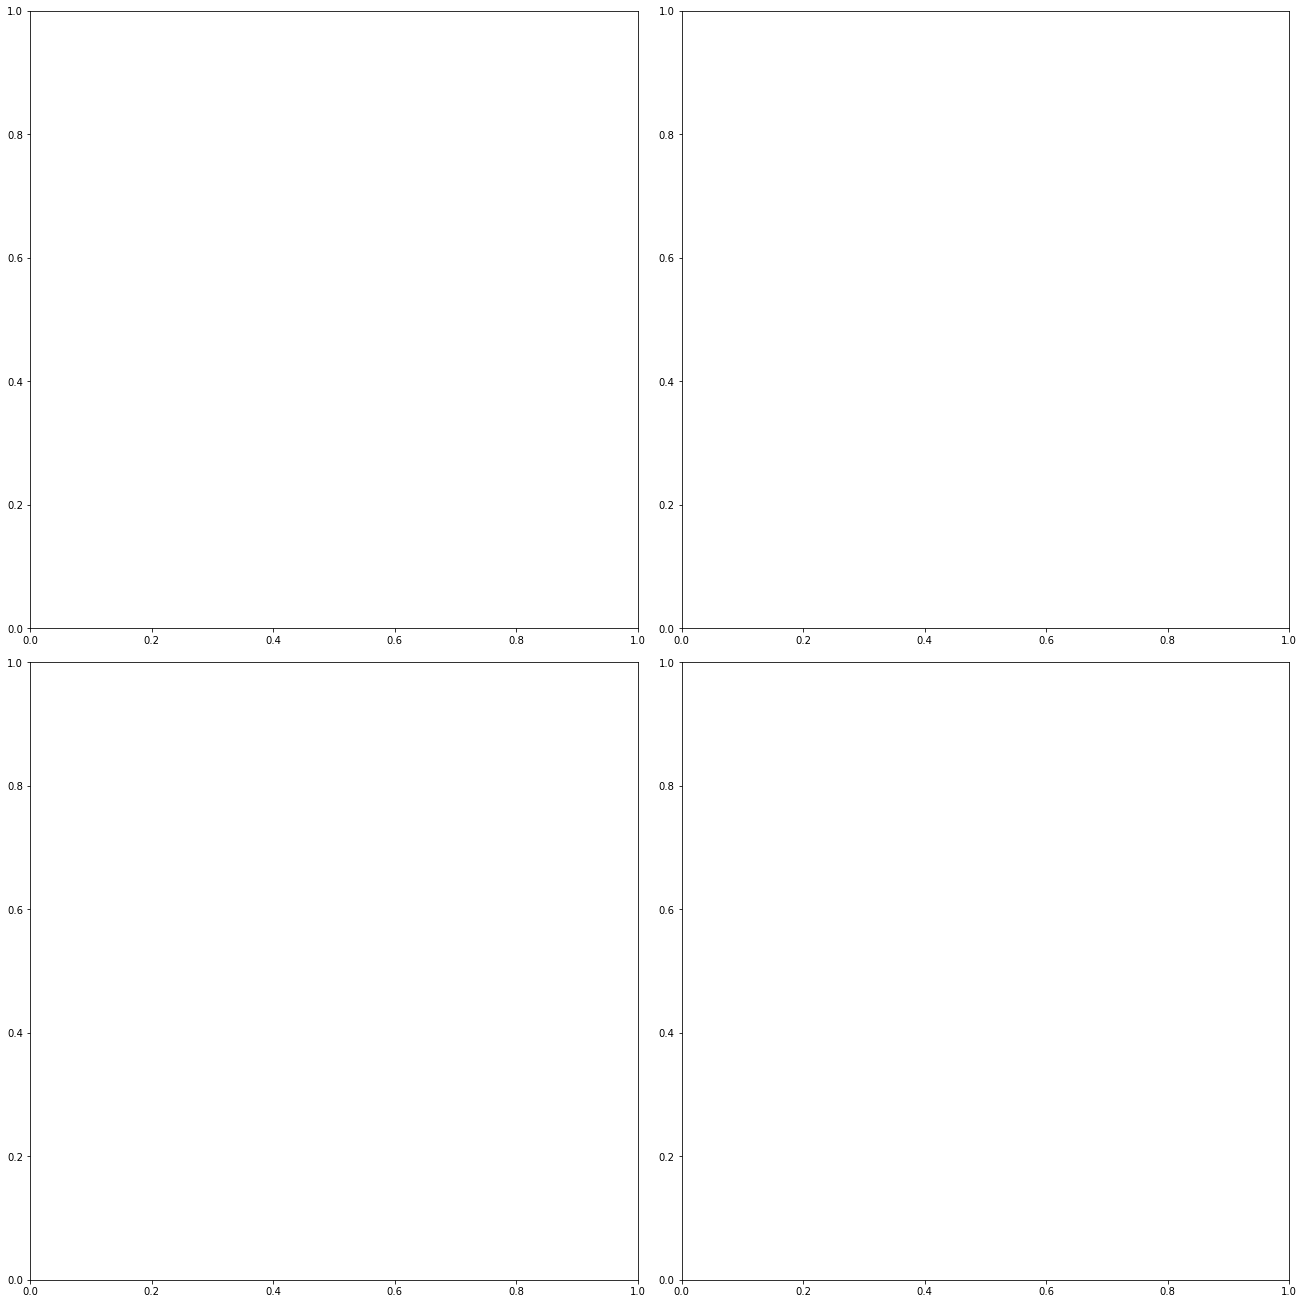

In [150]:
fig3, axs = plt.subplots(2,2,figsize=(18,18),layout='constrained')

In [151]:
p=axs[0,0].scatter(bhuvans['byg_arl_saml'],testplot['materialperm2'])
axs[0,0].set_ylabel('material per m2')
axs[0,0].set_xlabel('floor area')

Text(0.5, 654.67976, 'floor area')

In [152]:
axs[0,1].scatter(bhuvans['opfoerelse_aar'],testplot['materialperm2'])
axs[0,1].set_ylabel('material per m2')
axs[0,1].set_xlabel('construction year')

Text(0.5, 654.67976, 'construction year')

In [153]:
axs[1,0].bar(bhuvans['byg_anvend_kode'],testplot['materialperm2'])
axs[1,0].set_ylabel('material per m2')
axs[1,0].set_xlabel('use code')

Text(0.5, 3.1999999999999993, 'use code')

In [154]:
p=axs[1,1].hexbin(bhuvans['byg_anvend_kode'],bhuvans['opfoerelse_aar'],C=testplot['materialperm2'], reduce_C_function=np.mean, cmap='RdBu_r')
axs[1,1].set_xlabel('use code')
axs[1,1].set_ylabel('construction year')
fig3.colorbar(p, ax=axs[1,1])

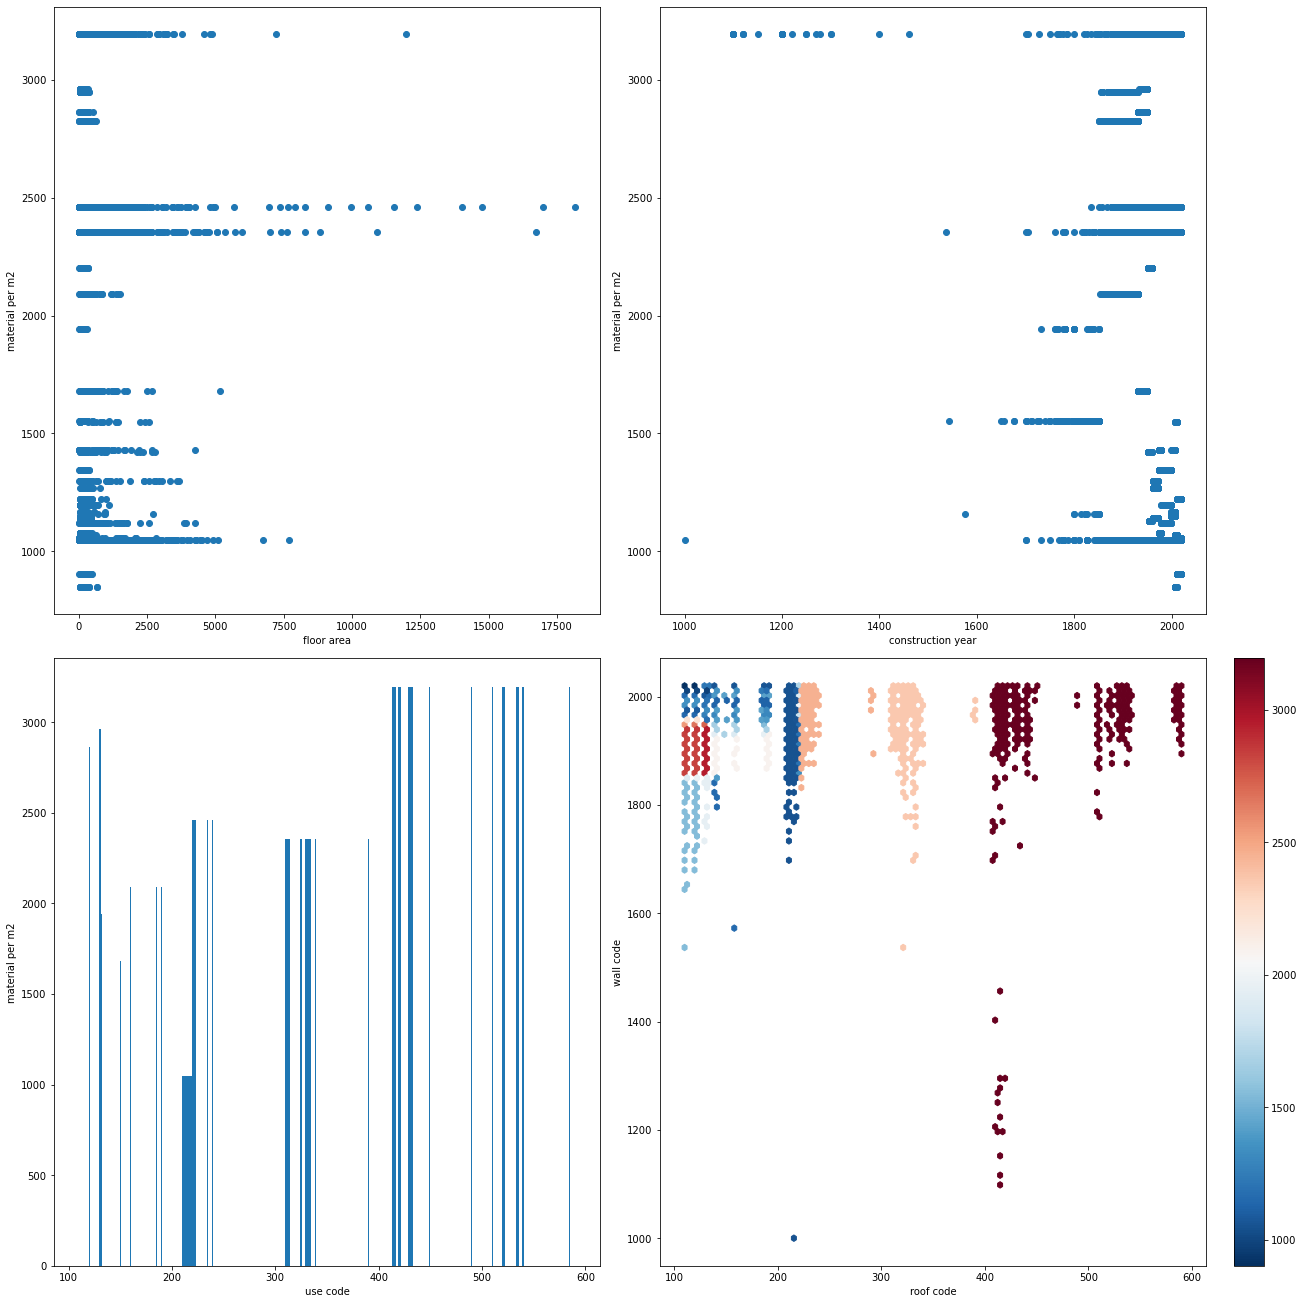

In [155]:
fig3.figure

In [ ]:
fig4, axs = plt.subplots(2,2,figsize=(18,18),layout='constrained')

p=axs[0,0].scatter(allresults['total_building_area'],testplot['amount'])
axs[0,0].set_ylabel('material per m2')
axs[0,0].set_xlabel('floor area')